# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Final Project Final Report

**Harvard University**<br/>
**Spring 2020**<br/>
**Group 32**: 

<hr style="height:2pt">

In [4]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## <a id='0'>Content</a>

- <a href='#1doc'>1. Introduction</a> 
- <a href='#2doc'>2. Exploratory Data Analysis</a>
    - <a href='#2a'>a. Data</a>
    - <a href='#2b'>b. EDA</a>
    - <a href='#2c'>c. EDA findings</a>  

- <a href='#3doc'>3. Models</a> 
    - <a href='#3a'>a. Baseline Model: Pre-trained BERT</a>
    - <a href='#3b'>b. Abstractive Seq2seq Model</a>
    - <a href='#3c'>c. LexRank Model</a>  
    - <a href='#3d'>c. Extractive GRU Model</a>  
- <a href='#4doc'>4. Conclusions</a> 


# <a id='1doc'>1. Introduction</a>


In this project, we will read case law, and generate automatic summarizations of the cases. Headnotes are brief case summary statements often generated by commercial third parties. Therefore, they are often under copyright protection, and are not always available to public or are subject to strict usage restrictions. Our goal is to construct a model to reconstruct these headnotes for a variety of cases using historical court cases as a training set. We will use data from [Caselaw Access Project](https://case.law/) by Harvard Law School. 

# <a id='2doc'>2. Exploratory Data Analysis</a>

**Contents**
- <a href='#2a'>a. Data</a>
- <a href='#2b'>b. EDA</a>
- <a href='#2c'>c. EDA findings</a>  

## <a id='2a'>a. Data</a>

In the Caselaw Access Project, there are four states (Arkansas, Illinois, New Mexico, North Carolina) with available bulk data. The data sets are available both in text format and xml format, but we will use the text format in the following analysis. In the datasets, each case is represented by a JSON object, which includes various information about the case. For example,

- `head_matter` represents all text printed in the volume before the text prepared by judges
- `opinions` contains a dictionary for each opinion in the case

There are following number of cases for North Carolina: 97,600
We focus on the North Carolina data at the recommendation of the TFs because they still made their headnotes publicly available for the Caselaw Access Project, in contrast to the other three states who limited recent head notes.

Note that we use the TEXT and not XML version of the data from the Caselaw Access Project site: https://case.law/bulk/download/

## <a id='2b'>b. Exploratory Data Analysis</a>
To perform exploratory data analysis, we compute word-length of headnotes and opinions in each case.

In [10]:
# libraries
from IPython.core.display import display, HTML
import json
import lzma
import pandas as pd
import numpy as np
import re
from nltk.tokenize import RegexpTokenizer
import datetime as dt

import matplotlib.pyplot as plt

#from bs4 import BeautifulSoup
#from tqdm import tqdm
#import seaborn as sns
#sns.set()

In [11]:
# defining a fucnction to remove \n and HTML tags
def text_cleaner(text):
    text_divided = text.splitlines()
    text_divided_clean = " ".join(text_divided)
    return text_divided_clean

In [117]:
# The file size for some states are too large to open into memory
# This function loads individual cases into memory, parses headnotes and 
# opinions, cleans the text, tokenizes the text, and returns counts of tokens
# for each case.

tokenizer = RegexpTokenizer('\s+', gaps=True)

def get_counts(state):
    cases = []
    cases_raw=[]
    headmatter = []
    with lzma.open('./North Carolina-20200416-text/data/data.jsonl.xz', 'r') as jsonl_file:
    #with lzma.open("../" + state + '-text/data/data.jsonl.xz', 'r') as jsonl_file:
        for case in jsonl_file:
            c = json.loads(str(case, 'utf-8'))
            cases_raw.append(c)
            
            date = c['decision_date']
            headnotes = text_cleaner(c['casebody']['data']['head_matter'])
            headmatter.append(headnotes)
            
            headnotes_tokenized = tokenizer.tokenize(headnotes)
            num_headnotes = len(headnotes_tokenized)

            opinions = c['casebody']['data']['opinions']
            if opinions == []:
                num_opinions = 0
            else:
                opinions = text_cleaner(opinions[0]['text'])
                opinions_tokenized = tokenizer.tokenize(opinions)
                num_opinions = len(opinions_tokenized)
            cases.append({'date':date, 'num_headnotes':num_headnotes, 'num_opinions':num_opinions})
        return pd.DataFrame(cases), headmatter, cases_raw

In [118]:
%%time

states = ['North Carolina']
counts_nc, headmatter_nc, cases_raw = get_counts(states[0])

CPU times: user 1min 32s, sys: 0 ns, total: 1min 32s
Wall time: 1min 32s


In [15]:
#counts_nc.to_csv('final_submission/counts_nc.csv', index=False)
#counts_nc.to_csv('csv/counts_nc.csv', index=False)

In [16]:
#counts_nc = pd.read_csv('./final_submission/counts_nc.csv')

In [17]:
print("number of cases, New Carolina:", counts_nc.shape[0])

number of cases, New Carolina: 97600


In [18]:
# Groups cases by the year of decision and returns the average number of tokens for headnotes and opinions.
def get_mean(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df_year = df.groupby('year').agg('mean')
    return df_year

In [19]:
counts_nc['date'] = pd.to_datetime(counts_nc['date'], errors='coerce')

In [20]:
year_nc = get_mean(counts_nc)

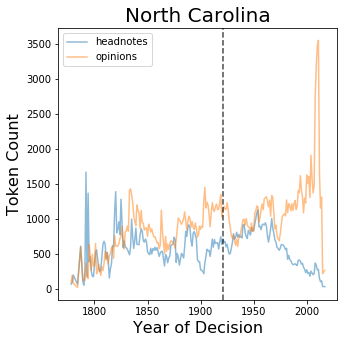

In [21]:
# Plots the average number of tokens for each state on a year by year basis. This plot
# shows how token counts vary over time as well as between states. Headnotes only 
# appear in case records up to 1920.

dfs = [counts_nc]

f, ax = plt.subplots(1,1, figsize=[5,5], sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.6)

df = get_mean(counts_nc)
ax.plot(df.num_headnotes, alpha=0.5, label='headnotes')
ax.plot(df.num_opinions, alpha=0.5, label='opinions')
ax.axvline(pd.Timestamp('1921').year, ls='--', color='k', alpha=0.7)
ax.set_title(states[0], fontsize=20)
ax.set_xlabel('Year of Decision', fontsize=16)
ax.set_ylabel('Token Count', fontsize=16)
ax.legend()

**Comments on Above Plots**

We see above that headnotes only appear in cases up to around 1920. We also see how the number of tokesn varies by year, with relatively stable token counts for opinions until near the 2000's, when we see a spike in length.

Text(0.5, 0, 'North Carolina')

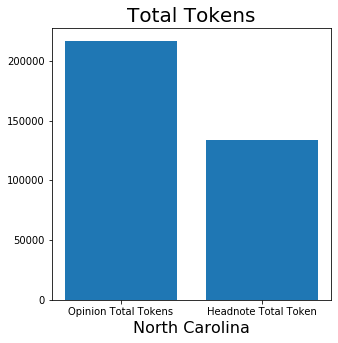

In [22]:
# The below functions and plots return summations of token counts for each state.

def headnote_total(df):
    return df['num_headnotes'].sum(axis=0)

def opinion_total(df):
    return df['num_opinions'].sum(axis=0)

f, ax = plt.subplots(1,1, figsize=[5,5])
ax.bar(['Opinion Total Tokens', 'Headnote Total Token'], [opinion_total(df), headnote_total(df)])
ax.set_title('Total Tokens', fontsize=20)
ax.set_xlabel('North Carolina', fontsize=16)

**Comments on the Above Plots**

The entire dataset has many more tokens for opinions than headnotes, this is due in part to headnotes stopping around 1920. 

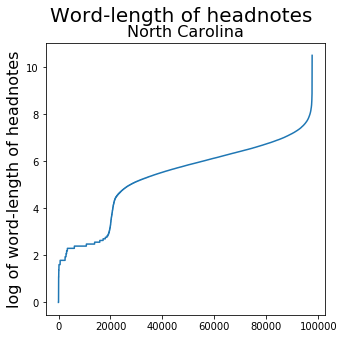

In [23]:
num_headnotes_nc = np.array(counts_nc.iloc[:,1])
num_headnotes_nc_sort = np.sort(num_headnotes_nc)

f, ax = plt.subplots(1,1, figsize=[5,5])
f.suptitle('Word-length of headnotes', fontsize=20)

ax.plot(range(len(num_headnotes_nc_sort)),np.log(num_headnotes_nc_sort))
ax.set_title('North Carolina', fontsize=16)
ax.set_ylabel('log of word-length of headnotes', fontsize=16)
plt.show()

The third figure is a plot of log(`word-length of headnotes`). For example, we see "elbows" at x$\approx$7, x$\approx$400, x$\approx$65000, and x$\approx$100000 in the plot of North Carolina. We focus at the elbow between (sort) indices 40000 and 70000 in the following figure.

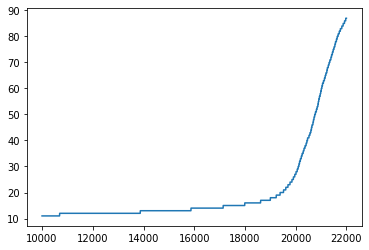

In [24]:
fig, ax = plt.subplots()
rnge_start = 10000
rnge_end = 22000
ax.plot(range(rnge_start, rnge_end),num_headnotes_nc_sort[rnge_start:rnge_end]);

Below, we are trying to find a general "boundary" with human-eye for when headmatters appears to become real summaries of opinion text, RATHER than just list of officials using North Carolina data.

In [25]:
hdnotes_df = pd.DataFrame(num_headnotes_nc, range(len(num_headnotes_nc)))
hdnotes_sort = hdnotes_df.sort_values(by=[0])
short_hds_lst = hdnotes_sort.loc[((hdnotes_sort[0]<80) & (hdnotes_sort[0]>50))]
short_hds_lst.head(10)

,0
26984,51
40567,51
44209,51
10091,51
97327,51
36041,51
93405,51
35333,51
8129,51
27109,51


Drawing from two of the idices noted above, we see that one case clearly is a real headmatter summary, while the other is just a list of officials involved. This suggests that somewhere between 50 to 80 words long, our headmatter can possibly be read by a human-being as a real summary headmatter.

In [26]:
print(headmatter_nc[26984])

Wilkinson, Assignee, vs. Wright. This was an action of debt brought in Hillsborough Superior Court, upon a bond which was made before the act passed in 1786, by which bonds were made negotiable. The question for the opinion of the court was, whether this action was maintainable by the assignee ?


In [27]:
print(headmatter_nc[40567])

STATE OF NORTH CAROLINA v. JIMMY T. DICKERSON No. 7314SC239 (Filed 14 March 1973) Appeal by defendant from Bailey, Judge, 28 August 1972 Session of Superior Court held in Durham County. Attorney General Robert Morgan by Emerson D. Wall, Assistant Attorney General, for the State. Jerry B. Clayton for defendant appellant.


## <a id='2c'>c. EDA findings</a>

If we were to face this data set "in the wild," we would proceed in this similar way: try to understand how legal case text is organized and find our target text elements (headmatter and opinion body text) and tokenize them. 

Our important metrics used were the number of tokens averaged per case by year for both headmatter and body text, and the length of headmatter per case. These help us decide what data is useful for our next step of generating a training set.

The right question to ask is: What data can we use to generate our own automated headnote/headmatter texts, based off of the case's opinion body text? Our data can answer this question by finding temporally (i.e. by year) where in our dataset we can find the most useful headnotes, as well as tell us based on length of headnotes whether the headnotes are usable for training a neural network on. 

In summary, our EDA achieves the following tasks:

1) Tokenize our data to prepare for later embedding steps

2) Visualize how the average headnote length has varied over the years to understand what years are usable as training/validation data

3) Visualization and "eye-estimate" the words-length of headnotes to figure out the best length for roughly classifying usable training data

Our next steps are to take what we learned from our EDA to produce a useable training set and then convert our text with an embedding to something intelligible to our algorithm.



# <a id='3doc'>3. Models</a>

<p>With our group of four, we decided to have each group member train a separate model to see which approach would best work summarizing legal cases. 

First, we found a baseline pre-trained BERT model, to see how one of the latest abstractive summarization models perform on our dataset.
    
Afterwards, we tried to develop an abstractive Seq2seq model ourselves, to emulate an abstractive approach to summarization.
    
We also tried an unsupervised LexRank approach (<a href='https://www.aaai.org/Papers/JAIR/Vol22/JAIR-2214.pdf'>Erkan and Radev 2004</a>), using which uses graph score ranking rather than neural network/machine learning to generate sentences. This performed significantly better than our abstractive model. 

In the end, we found that our final approach, using an extractive model based on SummaRuNNer (<a href='https://arxiv.org/abs/1611.04230'>Nallapati, Zhai, and Zhou 2016</a>) and NeuSum (<a herf='https://www.aclweb.org/anthology/P18-1061'>Zhou et al. 2018</a>) GRU architectures, outperformed our LexRank and baseline BERT models.</p>

**Contents:**
- <a href='#3a'>a. Baseline Model: Pre-trained BERT</a>
- <a href='#3b'>b. Abstractive Seq2seq Model</a>
- <a href='#3c'>c. LexRank Model</a>  
- <a href='#3d'>c. Extractive GRU Model</a>

In [54]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from rouge import Rouge

## <a id='3a'>a) Baseline Pre-trained BERT</a>

In [ ]:
headnotes = []
text_ops = []

for c in cases_raw:
    head = c['casebody']['data']['head_matter']
    op = c['casebody']['data']['opinions']
    
    #Do not append empty headnotes or empty opinion text
    if head and op:
        headnotes.append(head)
        text_ops.append(op[0]['text'])

In [294]:
df_nc = pd.DataFrame(zip(headnotes,text_ops), columns=["headnote", "opinion_text"]).reset_index()
df_nc.head()

,index,headnote,opinion_text
0,0,"SUPREME COURT,\nRALEIGH, (N. C.)\nJULY, 1810.\nThe State vs. John Owen.\nMurder.\nIn an indictment for murder the length and depth of the wound must be expressed. 2 Hawk. b. 2, c. 33, § 81. 2 Chit...","A majority of the court, therefore, being of the latter opinion, the bill of indictment was pronounced exceptionable: consequently, upon it sentence of death cannot bo passed , . 1 upon the prison..."
1,1,"Case No. 4,170.\nDUNLOP et al. v. WEST.\n[Brunner, Col. Cas. 27;\n2 Hayw. N. C. 346.]\nCircuit Court, D. North Carolina.\n1805.\n1\n[Reported by Albert Brunner, Esq., and here reprinted by permiss...","PER CURIAM.\nIf the sheriff or marshal seizes property in execution, and neglects to sell it, and is sued for his neglect, the plaintiff-shall recover damages to the amount of what the property wo..."
2,2,"Case No. 4,954.\nThe FORTUNA.\n[1 Brock. 299.]\nCircuit Court, D. North Carolina.\nSpring Term, 1815.\n1\n[Reported by John W. Brockenbrough. Esq.]\n2\n[Affirmed in 3 Wheat. 16 U. S.) 236.]","MARSHALL. Circuit Justice.\nThe Fortuna, a vessel sailing under Russian colors, was captured on a voyage from the Havanna to some port in Europe, by the American privateer Roger, and brought into ..."
3,3,"D. K. FUTCH v. ATLANTIC COAST LINE RAILROAD COMPANY.\n(Filed 15 October, 1919.)\n1. Carriers of Goods — Placing of Cars — Understanding of Agent — Instructions — Railroads.\nWhere damages are soug...","Walker, J.\nThe grievance alleged by the plaintiff is that the defendant failed to place a refrigerating car for him at Wrightsboro by 2 :30 o’clock p. m. on 16 Hay, 1918, to receive a certain lot..."
4,4,"MRS. SUSANNA WILLIAMS v. C. G. BAILEY, B. R. BAILEY et al., Executors of W. R. BAILEY.\n(Filed 3 December, 1919.)\n1. Deeds and Conveyances — Descriptions—Reference to Other Instruments— Wills.\nW...","Hoke, J.\nOn the hearing it appeared that C. G. Bailey and others, executors of the last will and testament of W. A. Bailey, deceased, intended presently to make sale of a tract of land in said co..."


In [298]:
# number of baseline cases to inspect 
baseline_size = 2#100

# randomly select 100 cases
baseline_data = df_nc.sample(n=baseline_size,replace=False, random_state=1)

#get text and summary 
baseline_text,baseline_summary = baseline_data.opinion_text.tolist(),baseline_data.headnote.tolist()


In [311]:
from summarizer import Summarizer
#https://github.com/dmmiller612/bert-extractive-summarizer
import rouge 

model = Summarizer()
rouge = rouge.Rouge()

# a function to get all scores from true summaries and generated summaries 
def getRougeScore(y_true,y_pred,metric='rouge-2',score='f'): 
    scores = np.zeros(len(y_true))
    for i in range(len(y_pred)):
        if y_pred[i] == '': # account for the possiblity that BERT fails and returns empty strings
            scores[i] = 0
            next
        else: 
            sc = rouge.get_scores(y_true[i], y_pred[i])
            scores[i] = sc[0][metric][score]
    print(np.mean(scores))
    return scores 

# a class to initialize, apply, and report baseline pre-trained BERT model performance
class Baseline_BERT_model(): 
    def __init__ (self,min_length=60): 
        super(Baseline_BERT_model,self).__init__()
        self.min_length = min_length
        
    def evaluate(self,texts,summaries):  
        results = []
        for i,text in enumerate(texts): 
            results.append(model(text,min_length=self.min_length))
        self.results = results
        self.summaries = summaries 
        return results 
    
    def reportEvaluation(self,metric='rouge-2',score='f'): 
        sc = getRougeScore(self.summaries,self.results,metric,score) 
        return sc
    def inspectOneSummary(self):
        # randomly inspect one summary 
        print(self.results[random.randint(0,len(self.results)-1)])
        

FileNotFoundError: [Errno 2] No such file or directory: '/usr/share/anaconda3/lib/python3.7/site-packages/summarizer/trainer/stop_words.txt'

In [310]:
bert = Baseline_BERT_model()

_ = bert.evaluate(baseline_text,baseline_summary)
print('The average Rouge 1 F-scores on 100 random cases is')
_ = bert.reportEvaluation(metric='rouge-1')
print('The average Rouge 2 F-scores on 100 random cases is')
_ = bert.reportEvaluation()

TypeError: 'Summarizer' object is not callable

In [9]:
bert.inspectOneSummary()

It appears therefrom that the plaintiff admits the purchase of the sewing machines at the price stated, but seeks to recover damages because, as it alleges, the defendant agreed to furnish the plaintiff an experienced and successful agent to sell the machines, and that said agent embezzled the horse and buggy furnished him and ran away with certain collections made by him. When furnished, the agent became the agent of the plaintiff, and any loss from his misconduct falls upon the plaintiff. He could not be the agent of both the plaintiff and defendant in selling machines for the plaintiff. The plaintiff company was engaged in the business of buying and retailing them. It is true' the reply denies that the plaintiff owes the sum set up in the counterclaim, but that is a conclusion of law, for the purchase and price of the sewing machines are admitted, and the liability therefor is denied solely on the ground that the agent recommended by the defendant and employed by plaintiff proved to

In [29]:
### INSERT YOUR CODE AND COMMENTS HERE 

## <a id='3b'>b) Abstractive Seq2Seq Model</a>


### <a id='0'>Content</a>

- <a href='#1'>1. Overview</a> 
- <a href='#2'>2. Data</a>
- <a href='#3'>3. Abstractive Seq2Seq Model</a>
- <a href='#4'>4. Abstractive Model Conclusion</a>  



### <a id='1'>1. Overview</a>

This method is a seq2seq with attention model that uses code from the following blog post as a basis.

https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

The model is designed to return an abstration of the case opinion that is trained on the headnotes in the dataset. 

### <a id=2>2. Data </a>

Long sequences caused this model to crash during training so the training dataset was cut down to around 5,000 cases that are in the bottom 30% of sequence length.

The text pre-processing is based on the blog listed above and it removes all punctuation and stop words from the case opinions and headnotes.

### <a id=3>3. Abstractive Seq2Seq Model <a/>
    
The model architecture utilizes both bidirectional LSTM layers and LSTM layers. Dropout layers are also utilized to regularize the model. This is a modification from the blog post that did not use bidirectional LSTM layers and that did not use dropout layers.

The optimizer was also changed from rmsprop to adam and the batchsize was experimented with and ultimetly selected as a balance between crashing the kernel and model performance.

Link to model is <a href=#abs_model>HERE</a>.

### <a id=4>4. Abstractive Model Conclusion<a/>

This model was not selected due to low rouge scores as well as poor performance in producing headnotes that appear relevant to a human reader. 

Adding two bidirectional layers in the encoder improved the rouge scores over the blog model and adding dropout layers slowed down the training and generally lead to improved validation accuracy over more epochs.

In [74]:
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")

from attention import AttentionLayer

# Installation for rouge here: https://pypi.org/project/rouge/
from rouge import Rouge

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/20765011/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [45]:
# function to process and format text

stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [36]:
# function to read data and apply text processing

def get_cases(state, subset=True, num_cases=100):
    cases = []
    with lzma.open(state+'-20200416-text' + '/data/data.jsonl.xz', 'r') as jsonl_file:
        for i, case in enumerate(jsonl_file):
            c = json.loads(str(case, 'utf-8'))

            date = c['decision_date']
            
            headnotes = c['casebody']['data']['head_matter']
            if headnotes == []:
                continue
            headnotes = text_cleaner(headnotes)
            num_head = len(headnotes)
            
            name = text_cleaner(c['name'])
            docket_number = text_cleaner(c['docket_number'])

            opinions = c['casebody']['data']['opinions']
            if opinions == []:
                continue

            opinions = text_cleaner(opinions[0]['text'])
            body = name + docket_number + opinions
            num_body = len(body)
                
            cases.append({'date':date, 'num_head':num_head, 'head':headnotes, 'num_body':num_body, 'body':body})
            if subset == True:
                if i > num_cases:
                    break
        return pd.DataFrame(cases)

In [37]:
# reading and cleaning case text

df = get_cases('North Carolina', subset=False, num_cases=10)
df['head'] = df['head'].apply(lambda x: '_START_ '+ x + ' _END_')
df.shape

(97586, 5)

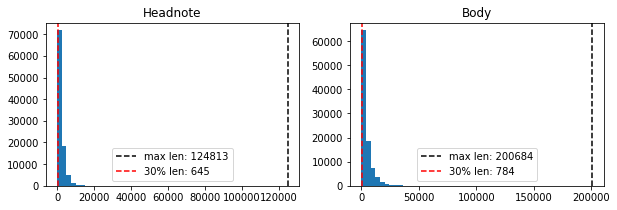

In [38]:
# Finding a threshold to subset the data due to challenges training on cases that
# have a long sequence length.

q = 30
q_head = int(np.percentile(df.num_head,q))
q_body = int(np.percentile(df.num_body,q))

f, ax = plt.subplots(1,2,figsize=[10,3])
ax[0].hist(df.num_head, bins=50)
ax[0].axvline(np.max(df.num_head), label='max len: ' + str(np.max(df.num_head)), color='k', ls='--')
ax[0].axvline(q_head, label=str(q) + '% len: ' + str(q_head), color='r', ls='--')
ax[0].set_title('Headnote')
ax[0].legend()
ax[1].hist(df.num_body, bins=50)
ax[1].axvline(np.max(df.num_body), label='max len: ' + str(np.max(df.num_body)), color='k', ls='--')
ax[1].axvline(q_body, label=str(q) + '% len: ' + str(q_body), color='r', ls='--')
ax[1].legend()
ax[1].set_title('Body')
plt.show()

In [39]:
# Selecting the subset of data for training. Cases with longer sequences caused
# problems with the kernel on Jupyter Hub crashing. The floor is set to try and 
# limit headnotes that are only a couple of words.

max_head = q_head
max_body = q_body

df = df[(df['num_head'] <= q_head) & (df['num_head'] > 20) & 
        (df['num_body'] <= q_body) & (df['num_body'] > 100)]
print(df.shape)
display(df[['num_head']].describe().T)
display(df[['num_body']].describe().T)

# display(df.head())
df.shape

(9473, 5)


,count,mean,std,min,25%,50%,75%,max
num_head,9473.0,177.891692,195.96236,21.0,27.0,52.0,343.0,645.0


,count,mean,std,min,25%,50%,75%,max
num_body,9473.0,255.33833,171.251366,101.0,130.0,178.0,328.0,784.0


(9473, 5)

In [ ]:
# df.to_json('df.json')
#df = pd.read_json('df.json')

113
97


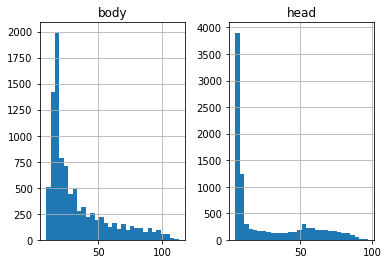

In [47]:
# plotting the word count in headnotes and opinions

text_word_count = []
summary_word_count = []

for i in df['body']:
      text_word_count.append(len(i.split()))

for i in df['head']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'body':text_word_count, 'head':summary_word_count})
max_head = length_df['head'].max()
max_body = length_df['body'].max()
print(max_body)
print(max_head)
length_df.hist(bins = 30)
plt.show()

In [48]:
# setting variables that will be used for inference and scoring

max_len_text = max_body
max_len_summary = max_head

In [49]:
# splitting the validation and training set on a 90/10 split

x_tr, x_val, y_tr, y_val = train_test_split(df['body'], df['head'], test_size=0.05, random_state=42)

In [50]:
# tokenize sequences
x_toke = Tokenizer()
x_toke.fit_on_texts(list(x_tr))
x_tr = x_toke.texts_to_sequences(x_tr)
x_val = x_toke.texts_to_sequences(x_val)

# padding
x_tr = pad_sequences(x_tr, maxlen=max_body, padding='post')
x_val = pad_sequences(x_val, maxlen=max_body, padding='post')

x_voc_size   =  len(x_toke.word_index) + 1

In [51]:
# tokenize sequences
y_toke = Tokenizer()
y_toke.fit_on_texts(list(y_tr))
y_tr = y_toke.texts_to_sequences(y_tr)
y_val = y_toke.texts_to_sequences(y_val)

# padding
y_tr = pad_sequences(y_tr, maxlen=max_head, padding='post')
y_val = pad_sequences(y_val, maxlen=max_head, padding='post')

y_voc_size   =  len(y_toke.word_index) + 1

### Abstractive Seq2seq Model <a id=abs_model></a>

In [55]:
# creating the model architecture

from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 
drop_out = 0.5

# Encoder 
encoder_inputs = Input(shape=(max_body,)) 
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs) 


#LSTM 1 
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output1, state_h1, state_c1, state_h1_backward, state_c1_backward = encoder_lstm1(enc_emb)
drop1 = Dropout(drop_out)(encoder_output1)

#LSTM 2 
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output2, state_h2, state_c2, state_h2_backward, state_c2_backward  = encoder_lstm2(drop1) 
drop2 = Dropout(drop_out)(encoder_output2)

#LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(drop2)

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 113)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 113, 500)     11424500    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 113, 1000),  4004000     embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 113, 1000)    0           bidirectional[0][0]              
______________________________________________________________________________________________

In [60]:
# compiling the model and training

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience = 3, mode='min', verbose=1)

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=10, batch_size=64, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
model.save_weights('model_blog_weights_bidirectional_5k.h5')

Train on 8999 samples, validate on 474 samples
Epoch 1/10
8999/8999 [==============================] - 313s 35ms/sample - loss: 1.8138 - val_loss: 1.7285
Epoch 2/10
8999/8999 [==============================] - 298s 33ms/sample - loss: 1.5494 - val_loss: 1.5507
Epoch 3/10
8999/8999 [==============================] - 301s 33ms/sample - loss: 1.3886 - val_loss: 1.4751
Epoch 4/10
8999/8999 [==============================] - 303s 34ms/sample - loss: 1.2771 - val_loss: 1.4358
Epoch 5/10
8999/8999 [==============================] - 300s 33ms/sample - loss: 1.1829 - val_loss: 1.4144
Epoch 6/10
8999/8999 [==============================] - 300s 33ms/sample - loss: 1.0989 - val_loss: 1.4037
Epoch 7/10
8999/8999 [==============================] - 300s 33ms/sample - loss: 1.0200 - val_loss: 1.4008
Epoch 8/10
8999/8999 [==============================] - 300s 33ms/sample - loss: 0.9457 - val_loss: 1.4037
Epoch 9/10
8999/8999 [==============================] - 300s 33ms/sample - loss: 0.8750 - val_los

In [ ]:
model.load_weights('model_blog_weights_bidirectional_5k.h5')

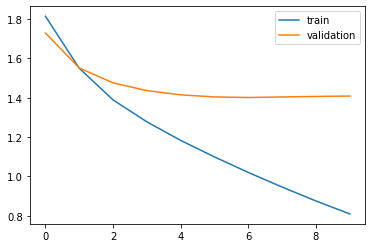

In [67]:
# plotting accuracy over epochs

plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='validation') 
plt.legend() 
plt.show()

In [68]:
# creating dictionaries for prediction and metrics

reverse_target_word_index = y_toke.index_word 
reverse_source_word_index = x_toke.index_word 
target_word_index = y_toke.word_index

In [69]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(inputs = [decoder_inputs] + 
                      [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                      outputs = [decoder_outputs2] + [state_h2, state_c2])

In [70]:
# setting the max headnote length below based off the plot above that shows this number will 
# capture the majority of headnotes in the training set

max_len_summary = 18

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        ### adding +1 for believed indexing of the word dictionary #######
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) #+ 1
        if sampled_token_index == 0:
            sampled_token = 'pad'
        ##################################################################
        else:
            sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [75]:
# functions to help with metrics and printing text

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [102]:
%%time
# calculating rouge 1 scores

rouge = Rouge()

metrics1 = []
metrics2 = []
for i in range(x_val.shape[0]):
    hypothesis = decode_sequence(x_val[i].reshape(1,max_len_text))
    reference = seq2summary(y_val[i])
    scores = rouge.get_scores(hypothesis, reference, avg=True)
    metrics1.append({'f':scores['rouge-1']['f'],
                    'p':scores['rouge-1']['p'],
                    'r':scores['rouge-1']['r']})
    metrics2.append({'f':scores['rouge-2']['f'],
                    'p':scores['rouge-2']['p'],
                    'r':scores['rouge-2']['r']})
    

CPU times: user 2min 43s, sys: 2min 56s, total: 5min 40s
Wall time: 5min 15s


In [103]:
metrics1_df = pd.DataFrame(metrics1)
metrics2_df = pd.DataFrame(metrics2)

In [104]:
#Rouge-1 scores
metrics1_df.mean()

f    0.065595
p    0.082403
r    0.105743
dtype: float64

In [105]:
#Rouge-2 scores
metrics2_df.mean()

f    0.009525
p    0.016614
r    0.008708
dtype: float64

In [107]:
# printing sample predictions

for i in range(3):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: state north carolina johnnie remand supreme court united states conformity opinion court hankerson north carolina ordered court conference defendant hereby awarded new trial see original opinion reported day september james exum associate justice court 
Original summary: state north carolina johnnie 
Predicted summary:  state north carolina john boyette criminal law appeal exception judgment presents face record proper review review review


Review: state rocky motion temporary stay state petition writ state pdr state petition writ certiorah review order coa allowed 
Original summary: state rocky williamson 
Predicted summary:  state north carolina john boyette criminal law appeal exception judgment presents face record proper review review review


Review: charles lester thorpe mary louise thorpe administrators estate charles thorpe ocean isle partners llc coastal corporation coastal carolina construction development inc development inc unidentified pdr denied 
Original summar

## <a id='3c'>c) LexRank Model</a>

In [108]:
import math
from collections import Counter

### <a id='0'>Content</a>

- <a href='#c1'>c-1. Introduction</a> 
- <a href='#c2'>c-2. Citation Filter</a>
- <a href='#c3'>c-3. Importing the legal documents</a>
- <a href='#c4'>c-4. LexRank Implementation</a>
- <a href='#c5'>c-5. Examples</a>
- <a href='#c6'>c-6. Challenges to thematic segmentation</a>
- <a href='#c7'>c-7. Conclusion</a>

### <a id='c1'>c-1. Introduction</a>

In order to summarize the legal texts, we also test the LexRank model, which is one of the ways for extractive summarization.

There are two ways to summarize texts using NLP; extractive and abstractive. Since the extractive approach chooses sentences from the original text, it is less likely to create an incomprehensible summary and less likely to output a gramatically incorrect summary. However, in the extractive approach, you cannot use words that are not in the original text, so it is not possible to paraphrase or to use conjunctions to make summary more easy to read. In contrast, the abstractive allows you to summarize more flexibly because you are free to use words that are not in the original sentences. In addition, you can choose the length of summary. However, the disadvantage in this approach is that it is difficult to produce "natural" sentences. For this project, we decided to take the extractive way to ensure that important information is included in the summary of the legal documents.

The LexRank model works almost the same as Google Search -- it uses sentences as a node and similarity as edge/weight. For details, please refer to [Erkan and Radev (2004)](https://www.aaai.org/Papers/JAIR/Vol22/JAIR-2214.pdf).

### <a id='c2'>c-2. Citation Filter</a>

According to [Farzindar and Lapalme (2004)](https://www.aclweb.org/anthology/W04-1006.pdf), the citations account for a large part of the text of the judgment, but they are not considered relevant for the summary. Therefore, I removed sentences that include specific abbreviation or words.

In [109]:
import re

# Reference: https://library.csustan.edu/apalegal

def citation_filter(text_list):
    new_list = []
    
    for i in range(len(text_list)):
        sentence = text_list[i]
        
        if re.search('\(\d\d\d\d\)', sentence) != None:
            pass
        elif re.search('v\.', sentence) != None:
            pass
        elif re.search('vs\.', sentence) != None:
            pass
        elif re.search('§', sentence) != None:
            pass
        elif re.search('R\.', sentence) != None:
            pass
        elif re.search('Rule', sentence) != None:
            pass
        # Ark. = Arkansas
        elif re.search('Ark\.', sentence) != None:
            pass
        else:
            new_list.append(sentence)
            
    return new_list

### <a id='c3'>c-3. Importing the legal documents</a>

In [110]:
# same as EDA
# defining a fucnction to remove \n and HTML tags
def text_cleaner(text):
    text_divided = text.splitlines()
    text_divided_clean = " ".join(text_divided)
    return text_divided_clean

In [119]:
# same as EDA
# The file size for some states are too large to open into memory
# This function loads individual cases into memory, parses headnotes and 
# opinions, cleans the text, tokenizes the text, and returns counts of tokens
# for each case.

tokenizer = RegexpTokenizer('\s+', gaps=True)

def graph_preprocess(cases_raw):
    cases = []
    for c in cases_raw:
        date = c['decision_date']
            
        headnotes = text_cleaner(c['casebody']['data']['head_matter'])
        headnotes_tokenized = tokenizer.tokenize(headnotes)
        num_headnotes = len(headnotes_tokenized)

        opinions = c['casebody']['data']['opinions']
        if opinions == []:
            num_opinions = 0
        else:
            opinions = text_cleaner(opinions[0]['text'])
            opinions_tokenized = tokenizer.tokenize(opinions)
            num_opinions = len(opinions_tokenized)
        cases.append({'date':date, 'num_headnotes':num_headnotes, 'headnotes': headnotes, 'num_opinions':num_opinions, 'opinions':opinions})
    return pd.DataFrame(cases)

In [120]:
%%time

# use North Carolina data as an example
counts_nc = graph_preprocess(cases_raw)

CPU times: user 1min 3s, sys: 0 ns, total: 1min 3s
Wall time: 1min 3s


### <a id='c4'>c-4. LexRank Implementation</a>

In [121]:
# compute term frequency
# Reference: http://www.tfidf.com/
# sentence: dictionary
def termfreq(sentence):

    dict_counts = Counter(sentence)
    max_tf = max(dict_counts.values())

    tf_dict = {}
    
    # create a dictionary with word + term frequncy
    for word, tf in dict_counts.items():
        tf_dict[word] = tf / max_tf
    
    # Output Example: {'word': tf, 'word': tf, ...}
    return tf_dict

# Create a dictionary with words and their IDF: Inverse Document Frequncy
# Reference: http://www.tfidf.com/
# list_sentences: list
def compute_idf(list_sentences):
    
    idf_dict = {}
    sentences_len = len(list_sentences)

    for sentence in list_sentences:
        for word in sentence:
            if word not in idf_dict:
                
                # if not in idf_dict, calculate idf and append it to the dictionary
                number_appearance = 0
                for sen in list_sentences:
                    if word in sen:
                        number_appearance += 1
                idf_dict[word] = math.log(sentences_len / number_appearance)
                
    return idf_dict

In [122]:
# Reference: http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume22/erkan04a-html/erkan04a.html
# Chapter 3 : Centrality-based Sentence Salience
def idf_modified_cosine(list_sentences, list_sentence_x, list_sentence_y):
    
    dict_x = termfreq(list_sentence_x)
    dict_y = termfreq(list_sentence_y)
    idf_dict = compute_idf(list_sentences)

    set_unique_words1 = set(list_sentence_x)
    set_unique_words2 = set(list_sentence_y)

    words_xy = set_unique_words1 & set_unique_words2
    
    numerator = 0
    for word in words_xy:
        numerator = numerator + dict_x[word] * dict_y[word] * ((idf_dict[word])**2)
        
    denominator_left_quad = 0
    for word in set_unique_words1:
        denominator_left_quad = denominator_left_quad + ((dict_x[word] * idf_dict[word]) ** 2)
        
    denominator_right_quad = 0
    for word in set_unique_words2:
        denominator_right_quad = denominator_right_quad + ((dict_y[word] * idf_dict[word]) ** 2)
    
    denominator_left = math.sqrt(denominator_left_quad) + 0.1
    denominator_right = math.sqrt(denominator_right_quad) + 0.1
    
    if denominator_left == 0 or denominator_right == 0:
        return 0
    else:
        return numerator / (math.sqrt(denominator_left) * math.sqrt(denominator_right))

In [123]:
# Reference: http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume22/erkan04a-html/erkan04a.html
# 3.2 Eigenvector Centrality and LexRank
# computing the stationary distribution of a Marcov chain
def power_method(M, N, eps):

    # initialization
    p = np.full((N,), 1/N)

    delta = 999

    while delta >= eps:
        p_t = np.dot(np.transpose(M), p)
        delta = np.linalg.norm(p_t - p)
        p = p_t

    return p

In [124]:
# Reference: http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume22/erkan04a-html/erkan04a.html
# 3.2 Eigenvector Centrality and LexRank, Algorithm #3

# Lexrank: summarizing sentences
# computing Lexrank Scores
def lex_rank(list_sentences, n, t):

    cosinematrix = np.zeros((n, n))
    degree = np.zeros((n,))

    for i in range(n):
        for j in range(n):
            cosinematrix[i][j] = idf_modified_cosine(list_sentences, list_sentences[i], list_sentences[j])
            if cosinematrix[i][j] > t:
                cosinematrix[i][j] = 1
                degree[i] += 1
            else:
                cosinematrix[i][j] = 0

    for i in range(n):
        for j in range(n):
            cosinematrix[i][j] = cosinematrix[i][j] / degree[i]

    L = power_method(cosinematrix, n, t)

    return zip(list_sentences, L)

### <a id='c5'>c-5. Examples</a>

#### Example 1

In [139]:
# Reference: https://nlpforhackers.io/splitting-text-into-sentences/

from pprint import pprint
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
 
trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(test_opinions)
 
tokenizer = PunktSentenceTokenizer(trainer.get_params())

In [140]:
test_opinions_list = tokenizer.tokenize(test_opinions)

In [141]:
def text_summarizer(text, n, t=1):
    """
    n: number of sentences
    t: error tolerance
    """
    words_list = []
    for i in range(len(text)):
        words = text[i].split()
        words_list.append(words)
    zipped = lex_rank(words_list, len(text), t)
    unzipped = list(zip(*zipped))
    scores = np.array(unzipped[1])
    highest_index = scores.argsort()[-n:][::-1]
    summarized = []
    high_scores = []
    for i in range(len(highest_index)):
        sentence = text[i]
        score = scores[i]
        high_scores.append(score)
        summarized.append(sentence)     
    print("\nOriginally", len(text), "sentences\n")
    print("Summarized in", n, "sentences\n")
    print("Summarized:  ", summarized,"\n")
    return summarized

In [ ]:
test_id1=975
test_opinions = counts_nc.iloc[test_id1,4]

In [142]:
%%time

# 616 words
num_of_sentences=15
result1 = text_summarizer(citation_filter(test_opinions_list), num_of_sentences, 0.1)


Originally 19 sentences

Summarized in 7 sentences

Summarized:   ['Rotmít, J. The action of the plaintiff would not be barred, if there had been no administrator lite, since the defendant held as bailee of the testator at his death, and would stand in the same situation to the executor.', 'The loss of the plaintiffs’ action and title, is supposed, then, to arise from the right of the administrator pendente lite, to demand and recover the slaves from the defendant.', 'It may be true, that such an administrator may sue for property which belonged to the deceased, as well as for a debt to him.', 'Yet, it may not follow, that the rights of the executor, after probate, are to be affected by the omission of the administrator to bring a suit of either kind.', 'Ilis powers and responsibilities are very limited.', 'He cannot be sued; nor can he sell any property, save only, from necessity — bona peritura.', 'If he brings a suit he cannot prosecute it after probate, because all his powers then

#### Rouge Scores

In [143]:
string1 = ''.join(result1)

rouge = Rouge()
scores = rouge.get_scores(string1, counts_nc.iloc[test_id1,2])
print("Original Headnote: ", counts_nc.iloc[test_id1,2], "\n\n")
print("Rouge F1 Score:", scores[0]['rouge-1']['f'], "Rouge F2 Score:", scores[0]['rouge-2']['f'])

Original Headnote:  WM. T. WOOTEN, Adm’r. de bonis non, v. SARAH JARMAN. Where a slave was placed by a father in the possession of a daughter, and remained in such possession until the father’s death, after which an issue was made up to try the validity of his will, which pended for eight years, when the will was established, it was Held that a demand made by an administrator pendente lite and a refusal, did not make the daughter’s possession adverse to the rights of the executor proper, and he was not barred by three years possession, under such circumstances. ActioN of TROVER, tried before Heath, J., at the last Fall Term of Lenoir Superior Court. The action is trover for a female slave, Chaney, and her five children. It was originally brought by John Davis, the executor of Windall Davis, deceased; and upon the death of the executor, was revived by the present plaintiff, as administrator de "bonis non, cum tes. cm. It was tried on the general issue and the statute of limitations, and

In [274]:
print("Generated summary:")
print(string1)

Generated summary:
Rotmít, J. The action of the plaintiff would not be barred, if there had been no administrator lite, since the defendant held as bailee of the testator at his death, and would stand in the same situation to the executor.The loss of the plaintiffs’ action and title, is supposed, then, to arise from the right of the administrator pendente lite, to demand and recover the slaves from the defendant.It may be true, that such an administrator may sue for property which belonged to the deceased, as well as for a debt to him.Yet, it may not follow, that the rights of the executor, after probate, are to be affected by the omission of the administrator to bring a suit of either kind.Ilis powers and responsibilities are very limited.He cannot be sued; nor can he sell any property, save only, from necessity — bona peritura.If he brings a suit he cannot prosecute it after probate, because all his powers then, cease by their own limitation; and, until the recent act of 1854, the ex

#### Example 2

In [286]:
test_id2=9588
test2_opinions = counts_nc.iloc[test_id2,4]
test2_opinions_list = tokenizer.tokenize(test2_opinions)

In [ ]:
%%time
num_of_sentences=20
result2 = text_summarizer(citation_filter(test2_opinions_list), num_of_sentences, 0.1)

#### Rouge Scores

In [288]:
string2 = ''.join(result2)

rouge = Rouge()
scores = rouge.get_scores(string2, counts_nc.iloc[test_id2,2])
print("Original Headnote: ", counts_nc.iloc[test_id2,2], "\n\n")
print("Rouge F1 Score:", scores[0]['rouge-1']['f'], "Rouge F2 Score:", scores[0]['rouge-2']['f'])

Original Headnote:  J. WESLEY MOREFIELD, Administrator of J. C. Foddrill, v. W. E. HARRIS. (Decided May 22, 1900.) Administrator Appointed in Another State — Ancillary Administrator Appointed Sere — Bona Noiabilia — Attachment Issued by Justice — Lien, When. 1. An administrator can not sue in this State by virtue of his appointment in another State. There must be an ancillary administrator appointed here. •2. A transcript of judgment obtained by the administrator and brought here is sufficient notabilia to warrant the appointment of such ancillary administration. 3. Attachment issued by Justice creates a lien from its levy, and not merely from docketing of the judgment in Superior Court. Code, sec. 354. Civil ActioN, with attachment proceedings, heard on appeal from Justice’s Court before Allen, J., at Spring Term, 1899, of the Superior Court of Stokes County. T. M. Eoddrill, administrator of J. C. Eoddrill, in Georgia, obtained a judgment in Georgia against the defendant, W. E. Harris

In [289]:
print("Generated summary:")
print(string2)

Generated summary:
Petition for writ of certiorari to North Carolina Court of Appeals denied 8 November 1974.


#### Rouge F1 & F2 With the first 100 observations

In [155]:
def text_summarizer_simple(text, n, t=1):
    """
    n: number of sentences
    t: error tolerance
    """
    words_list = []
    for i in range(len(text)):
        words = text[i].split()
        words_list.append(words)
    zipped = lex_rank(words_list, len(text), t)
    unzipped = list(zip(*zipped))
    scores = np.array(unzipped[1])
    highest_index = scores.argsort()[-n:][::-1]
    summarized = []
    high_scores = []
    for i in range(len(highest_index)):
        sentence = text[i]
        score = scores[i]
        high_scores.append(score)
        summarized.append(sentence)     
    return summarized

In [193]:
%%time

#num_sent: number of sentences in the summary
num_sents = 20

score_100_f1 = 0
score_100_f2 = 0

counter = 0
counter_100 = 0

while counter_100 < 100:
    
    row_num = 57000 + counter

    # use texts shorter than 2000 to save computation
    # excludes case body text that are shorter than our desired summary length
    if (counts_nc.iloc[row_num,3] > 2000) or (counts_nc.iloc[row_num,3]<=num_sents):
        counter += 1
    else:
        
        test100_opinions = counts_nc.iloc[row_num,4]
        test100_opinions_list = tokenizer.tokenize(test100_opinions)
        #print('pre ')
        result100 = text_summarizer_simple(citation_filter(test100_opinions_list), num_sents, 0.1)
        #print('post ')
        string100 = ''.join(result100)
        
        rouge = Rouge()
        scores = rouge.get_scores(string100, counts_nc.iloc[row_num,2])
        
        score_100_f1 += scores[0]['rouge-1']['f']
        score_100_f2 += scores[0]['rouge-2']['f']
        
        counter += 1
        counter_100 += 1
        
print("Average Rouge F1 Score:", score_100_f1 / 100, "\n")
print("Average Rouge F2 Score:", score_100_f2 / 100)

Average Rouge F1 Score: 0.24098430096654347 

Average Rouge F2 Score: 0.09616493625718704
CPU times: user 40min 34s, sys: 0 ns, total: 40min 34s
Wall time: 40min 32s


In [195]:
print("Number of skipped cases: {}".format(counter))

Number of skipped cases: 305


### <a id='6'>6. Challenges to thematic segmentation</a>

In [Farzindar and Lapalme (2004)](https://www.aclweb.org/anthology/W04-1006.pdf), thematic segmentation by linguistic markars is introduced as a way to more easily summarize legal documents. This is because we can follow the structure of legal documets, and we are less likely to miss important information. We tried to implement the thematic segmentation, but we observed, for example, linguistic markars for conclusion in the beginning of a legal document. Therefore, we decided not to use thematic segmentation for summarization.

In [196]:
# Reference: https://www.aclweb.org/anthology/W04-1006.pdf

markars_introduction = ['application for judicial review', 'application to review a decision', 'motion filed by', 'Statement of Claim']

markars_context = ["advise","indicate","concern","request"]

markars_juridical_analysis = ['this court','In reviewing',
                            'Pursuant to section','As I have stated','In the present case']

markars_conclusion = ['note','accept','summarise','scrutinize','think','say','satisfy','discuss','conclude','find','believe','reach','persuade',
                      'agree','indicate','review']

In [197]:
markars = [markars_introduction, markars_context, markars_juridical_analysis, markars_conclusion]

def markar_detector(text_list):
    for i in range(len(text_list)):
        sentence = text_list[i]
        
        for markar in markars:
            for j in range(len(markar)):
                markar_word = markar[j]
                TF = markar_word in sentence
                if TF == True:
                    if markar == markars_context:
                        type_markar = "context"
                        print("Linguistic markar '"+markar_word+"' detected! Sentence #", i, "of "+str(len(text_list))+". This is",type_markar,"markar.")
                    elif markar == markars_juridical_analysis:
                        type_markar = "juridical analysis"
                        print("Linguistic markar '"+markar_word+"' detected! Sentence #", i, "of "+str(len(text_list))+". This is",type_markar,"markar.") 
                    else:
                        type_markar = "conclusion"
                        print("Linguistic markar '"+markar_word+"' detected! Sentence #", i, "of "+str(len(text_list))+". This is",type_markar,"markar.")   

In [199]:
test_text4 = counts_nc.iloc[10,4]
test_text_list4 = tokenizer.tokenize(test_text4)

markar_detector(test_text_list4)

Linguistic markar 'review' detected! Sentence # 6 of 29. This is conclusion markar.
Linguistic markar 'review' detected! Sentence # 7 of 29. This is conclusion markar.
Linguistic markar 'say' detected! Sentence # 11 of 29. This is conclusion markar.
Linguistic markar 'reach' detected! Sentence # 12 of 29. This is conclusion markar.
Linguistic markar 'conclude' detected! Sentence # 17 of 29. This is conclusion markar.
Linguistic markar 'review' detected! Sentence # 23 of 29. This is conclusion markar.


### <a id='7'>7. LexRank Conclusion</a>

Although the LexRank Model summarizes the legal documents with a reasonably long headnote well, the average Rouge F1 and F2 are not so good because we fixed the length of summary to be 20 and it is not flexible. There are a couple of ways to improve the LexRank model.

- We might miss conclusion (juridical decision) because we do not implement thematic segmentation and the model cannot recognize the conclusion sentences as important.
- Regarding thematic segmentation, we should have better lists of linguistic markars. In addition, we could set a stop condition for thematic segmentation (e.g. if we observe conclusion markars N times in a row, we recognize all the texts after that as conclusion.)
- We should also think about the citation filter as headnotes include citations especially in conclusion. We should not the citation filter for summarizing conclusion. (But in order to achieve it, we need to implement thematic segmentation.)

## <a id='3d'>d) Extractive GRU Model</a>

- d-1. Separate Pre-Processing for Extractive Model
    - <a href='#d1a'>a. Tokenizing sentences and words</a> 
    - <a href='#d1b'>b. Oracle</a> 
    - <a href='#d1c'>c. Further Pre-processing: X_train</a> 
    - <a href='#d1d'>c. Further Pre-processing: Y_train labels</a> 
- d-2. The Model
    - <a href='#d2a'>a. Build embedding layer</a> 
    - <a href='#d2b'>. Build GRU-GRU model</a> 
- d-3. Generating and Scoring Summary
    - <a href='#d3a'>a. Find Rouge Score</a> 
    - <a href='#d3b'>b. Concluding Remarks on Extractive Model</a> 

In [200]:
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
pd.set_option("display.max_colwidth", 200)

[nltk_data] Downloading package punkt to /home/20765011/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### d-1. Separate Pre-Processing for Extractive Model

### <a id='d1a'>a. Tokenizing sentences and words</a>
Unlike abstractive modeling, we need to tokenize by sentence as well as by words for this particular extractive model. Our model needs data that has clear sentence markers, to be able to extract/select the best sentences for making a summary.

In [201]:
sentence_tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [203]:
# Use North Carolina Text, not XML files from here: https://case.law/bulk/download/

headnotes = []
text_ops = []

for c in cases_raw:
    head = c['casebody']['data']['head_matter']
    op = c['casebody']['data']['opinions']
    
    #Do not append empty headnotes or empty opinion text
    if head and op:
        headnotes.append(head)
        text_ops.append(op[0]['text'])

In [204]:
%%time
# Cap body texts to 3000 words, due to limits of our GPU
max_body_word_count = 3000
token_ops = []
op_word_counts = []
for i, op in enumerate(text_ops):
    results = sentence_tokenizer.tokenize(op)
    results = ' ##SENT## '.join(results)
    # Cut off tokens at max allowed count
    tokens = tokenizer.tokenize(results)[:max_body_word_count]
    op_word_counts.append(len(tokens))
    results = ' '.join(tokens)
    token_ops.append(results)

CPU times: user 4min 58s, sys: 0 ns, total: 4min 58s
Wall time: 4min 57s


In [205]:
%%time
# Cap head notes to 2000 words
max_head_word_count = 2000
token_heads = []
head_word_counts = []
for i, head in enumerate(headnotes):
    results = sentence_tokenizer.tokenize(head)
    results = ' ##SENT## '.join(results)
    tokens = tokenizer.tokenize(results)[:max_head_word_count]
    head_word_counts.append(len(tokens))
    results = ' '.join(tokens)
    token_heads.append(results)

CPU times: user 2min 11s, sys: 0 ns, total: 2min 11s
Wall time: 2min 11s


In [206]:
# Drop all cases with headnotes under 50 words, because our EDA shows
# that they tend to not be true head notes, but just list of names
df = pd.DataFrame(list(zip(token_ops, token_heads, op_word_counts, head_word_counts)), columns=('token_ops', 'token_heads', 'op counts', 'head counts'))
df = df.loc[df['head counts']>50]

# Drop all cases where summaries are longer than 1/2 word-length of body text
# Mainly because when headnotes are as long as their opinion text,
# they arguably are not really "summaries" anymore by that point.
df = df.loc[df['op counts']>df['head counts']*2]
len(df)

33785

In [ ]:
# Export csv to prepare for Oracle step
##df[:24000].to_csv("true_df.csv")

### <a id='d1b'>b. Oracle</a>
This is used as an unsupervised way to generate the "true labels" (e.g. best sentences to extract) from the true head note. 
This particular algorithm is from the Zhou et al piece "Neural Document Summmarization by Jointly Learning to Score and Select Sentences," found here: https://www.aclweb.org/anthology/P18-1061.pdf. The model they use is called NeuSum.

This algorithm constructs the training data set by labelling sentences in a given document as part of the summary or not, based on maximizing the Rouge-2 F1 score. 

Because our documents for these cases are so much longer than the CNN/Daily Mail dataset used by Zhou et al for NeuSum, the below process takes far longer to find labels, and also it does not explore all possible combinations of sentences--otherwise, the algorithm would take far too long to find all the best labels.

In [207]:
# Borrowed from: https://github.com/magic282/cnndm_acl18/blob/master/find_oracle.py

import sys
import itertools
import gc
from PyRouge.Rouge.Rouge import Rouge as rouge_ds

#This entire cell creates functions that help find the best extractive sentences,
# i.e. "highlights", based on maximizing Rouge-2 F1 score, using real summaries/headnotes as
# points of reference

#Document type object makes it easier to handle summaries and body text
class Document(object):
    def __init__(self, doc_sents, summary_sents):
        self.doc_sents = doc_sents
        self.summary_sents = summary_sents
        self.doc_len = len(self.doc_sents)
        self.summary_len = len(self.summary_sents)
        self.concat_summary = " ".join(self.summary_sents)

rouge = rouge_ds(use_ngram_buf=True)

#rouge = Rouge(use_ngram_buf=True)

MAX_COMB_L = 5
MAX_COMB_NUM = 100000

# Generates the number of possible sentence combinations
def c_n_x(n, x):
    if x > (n >> 2):
        x = n - x
    res = 1
    for i in range(n, n - x, -1):
        res *= i
    for i in range(x, 0, -1):
        res = res // i
    return res

# Finds the best "highlights", i.e. best sentences, for extraction from one document
def solve_one(document):
    if document.doc_len == 0 or document.summary_len == 0:
        return None, 0
    sentence_bigram_recall = [0] * document.doc_len
    for idx, sent in enumerate(document.doc_sents):
        scores = rouge.compute_rouge([document.summary_sents], [sent])
        recall = scores['rouge-2']['r'][0]
        sentence_bigram_recall[idx] = recall
    candidates = []
    for idx, recall in enumerate(sentence_bigram_recall):
        if recall > 0:
            candidates.append(idx)
    all_best_l = 1
    all_best_score = 0
    all_best_comb = None
    for l in range(1, len(candidates)):
        if l > MAX_COMB_L:
            #print('Exceed MAX_COMB_L')
            break
        comb_num = c_n_x(len(candidates), l)
        if math.isnan(comb_num) or math.isinf(comb_num) or comb_num > MAX_COMB_NUM:
            #print('Exceed MAX_COMB_NUM')
            break
        combs = itertools.combinations(candidates, l)
        l_best_score = 0
        l_best_choice = None
        for comb in combs:
            c_string = [document.doc_sents[idx] for idx in comb]
            rouge_scores = rouge.compute_rouge([document.summary_sents], [c_string])
            rouge_bigram_f1 = rouge_scores['rouge-2']['f'][0]
            if rouge_bigram_f1 > l_best_score:
                l_best_score = rouge_bigram_f1
                l_best_choice = comb
        if l_best_score > all_best_score:
            all_best_l = l
            all_best_score = l_best_score
            all_best_comb = l_best_choice
        else:
            if l > all_best_l:
                break
    return all_best_comb, all_best_score

# Finds all best combination of sentences for all documents, using helper function solve_one
def solve(documents, output_file):
    writer = open(output_file, 'w', encoding='utf-8', buffering=1)
    for idx, doc in enumerate(documents):
        if idx % 100 == 0:
            print(dt.datetime.now())
            rouge.ngram_buf = {}
            gc.collect()
        comb = solve_one(doc)
        writer.write('{0}\t {1}'.format(comb[0], comb[1]) + '\n')
    writer.close()

# Correctly loads data so that function "solve" can read it
def load_data(src_file, tgt_file):
    docs = []
    for src_line, tgt_line in zip(src_file, tgt_file):
        src_line = src_line.strip()
        tgt_line = tgt_line.strip()
        src_sents = src_line.split('##SENT##')
        tgt_sents = tgt_line.strip().split('##SENT##')
        docs.append(Document(src_sents, tgt_sents))
    return docs

# Executes the entire process of finding best extractive sentences from documents
def find_highlights(src_file, tgt_file, outfile_name):
    docs = load_data(src_file, tgt_file)
    solve(docs, outfile_name)

In [208]:
%%time
# This takes 72+ hours of processing
# This was run parallel on multiple machines to speed up processing


# Rename output file to "full_oracle.txt" instead, but this will overwrite the actual full_oracle.txt 
# that took 48+ hours to run.
# Also must change end to = 24000
output_file = "full_oracle_.txt"
start = 0 
end = 2 #24000
find_highlights(df['token_ops'][start:end], df['token_heads'][start:end], output_file)

2020-05-08 22:28:19.034250
CPU times: user 24.1 s, sys: 0 ns, total: 24.1 s
Wall time: 24.1 s


### <a id='d1c'>c. Further Pre-processing: X_train</a>

In [262]:
# true_df.csv can be found in this zip file that Song generated for paralelling pre-processing:
#https://drive.google.com/open?id=151hFYYsj7_dz0oXzUXePbQ6E04xdXUPA

#df = pd.read_csv("true_df.csv")

In [209]:
#Adjust df to match the y_train that we pre-processed by batching
df = df.iloc[:24000]

##### i. X_train: Generate vocabulary via tokenization for embeddings

In [210]:
# I don't need to get embeddings for headnote tokens, because our
# RNN will only extract sentences from the opinion body text;
# thus, my model never needs to "read" the headnotes
all_text = df['token_ops']

# Text cleaner removes numbers and punctuation, as they are probably not needed
# for the model to evaluate the IMPORTANCE of a sentence (not meaning).
# It also decreases the size of our input, for the sake of our GPU

def txt_cleaner(text):
    newString = re.sub('"','', text)
    
    #added line to remove parantheses
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString) # remove '"'
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [211]:
%%time
# all_text: all the text, tokenized for generating the vocabulary, which we need for embedding
# df_cleaned: the cleaned dataframe with punctuations/numbers removed

all_text = []
df_cleaned = []

for doc in df['token_ops']:
    x = doc.replace("##SENT##", "newsenthere")
    x = txt_cleaner(x)
    df_cleaned.append(x)
    
    x_tok = nltk.tokenize.WordPunctTokenizer().tokenize(x)
    all_text.extend(x_tok)

CPU times: user 47 s, sys: 0 ns, total: 47 s
Wall time: 47 s


In [212]:
# words: all the unique words in our entire training text set
# We will use this to generate embedding layer later
words = np.unique(all_text)
n_words = len(words)

# Add padding at position 0, and 'zzzzzz' because for some reason, it was not in our unique words list
word_index = ['_PADDING_'] +  ['zzzzzzz'] + list(words)

print("Vocab size: {}".format(n_words))

Vocab size: 113816


##### ii. X_train: Find maximum length of sentences to cap dataset at

In [213]:
%%time
# Find how long each sentence in our training set is, to see what max_sentence length is.
# We need max_sent_len in order to do padding.
# We need padding because we will MaxPool our words into sentences, so need consistent sentence length

sent_lengths = []
for doc in df['token_ops']:
    sents_in_doc = doc.split('##SENT##')
    sent_lengths.append(len(sents_in_doc))

CPU times: user 434 ms, sys: 0 ns, total: 434 ms
Wall time: 432 ms


Text(0, 0.5, '# of sentences with x word length')

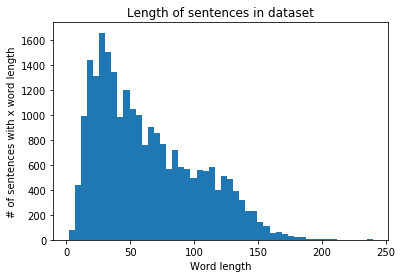

In [214]:
plt.hist(np.sort(sent_lengths), bins=50)
plt.title("Length of sentences in dataset")
plt.xlabel("Word length")
plt.ylabel("# of sentences with x word length")

In [215]:
# We see that 91% of our sentences have lengths less than 130 words
# So we arbitrarily pick this as our max sentence length
# NOTE: I tried longer sentence lengths, but the JupyterHub GPU crashes
max_idx = np.argmax(np.sort(sent_lengths) >130)
max_idx/df.shape[0]

0.9289166666666666

In [216]:
# Set max words per sentence to 130
# Use this size for maxpooling layer
max_words_in_sent = 130 #max(sent_lengths)
print(max_words_in_sent)

130


In [217]:
# dictionary for word index (vocabulary)
word2idx = dict(zip(word_index, range(n_words+1)))
idx2word = dict(zip(range(n_words+1), word_index))

##### iii. X_train: enerate X_train from cleaned data

In [218]:
%%time
# convert to numeric using word2idx and add padding
X = []
for doc in df_cleaned:
    sents_in_doc = doc.split('newsenthere')
    
    mod_doc = []
    for sent in sents_in_doc:
        mod_sent=[]
        x_tokens = nltk.tokenize.WordPunctTokenizer().tokenize(sent)
        # Convert tokens in a sentence to index numbers
        for token in x_tokens:
            mod_sent.append(word2idx[token])
        mod_doc.append(mod_sent[:max_words_in_sent])
    X.append(pad_sequences(mod_doc, maxlen=max_words_in_sent, padding='post', value=0))

CPU times: user 37 s, sys: 0 ns, total: 37 s
Wall time: 37 s


In [219]:
# Generate the X_train
X_train = []
for doc in X:
    concat_doc = []
    for sent in doc:
        concat_doc.extend(sent)
    X_train.append(concat_doc)
len(X_train)

24000

In [220]:
# cap max senteces per doc to 110 sentences * 130 words per sent, cuz above max_length is too large
sents_per_doc =110
max_doc_len = sents_per_doc*max_words_in_sent
max_doc_len

14300

In [221]:
# Pad documents so that they are all the same number of sentences
X_tr_final = pad_sequences(X_train, maxlen=max_doc_len, padding='post', value=0)

In [222]:
X_tr_final.shape

(24000, 14300)

### <a id='d1d'>c. Further Pre-processing: Y_train labels</a>

In [223]:
# 2000 oracle iterations take 8 hours, so doing the full pre-processing
# was not a feasible option.

In [225]:
# Builds unprocessed y_train (y_unproc) with a tuple of best sentence indices per document
# Also builds F1 Rouge-2 scores, calculated during pre-processing

# Borrowed from https://stackoverflow.com/questions/6633678/finding-words-after-keyword-in-python
y_unproc=[]
rouge_scores=[]

f = open("./oracle/ffull_oracle.txt", "r")
for line in f:
    y_tup, split, rouge_score = line.partition('\t')
    rouge_score = rouge_score.strip('\n')
    y_unproc.append(y_tup)
    rouge_scores.append(rouge_score)

In [226]:
# Find indices of N/A to drop later from x_train and y_train
null_y = []
for i in range(len(y_unproc)):
    if y_unproc[i] == 'None':
        null_y.append(i)

print("# of nulls: {}".format(len(null_y)))

# Drop nulls
X_tr_final = np.delete(X_tr_final, null_y, axis=0)
y_unproc = np.delete(y_unproc, null_y, axis=0)

# of nulls: 114


In [227]:
# set length of our y_train
y_len = len(y_unproc)
y_len

23886

In [228]:
# This generates the lbinary abels for each word in a sentence (0 or 1, 1 being it is a chosen extracted summary sentence)

# initialize zeros in the correct y_train shape
y_full = np.zeros(shape=(y_len, sents_per_doc))
for i in range(y_len):
    if y_unproc[i] != 'None':
        y_p = y_unproc[i].strip('(),').split(', ')
        y_tpl = tuple(map(int, y_p))
        for j in y_tpl:
            if j < sents_per_doc:
                y_full[i][j] = 1.

In [229]:
y_full.shape

(23886, 110)

### d-2. The Model

### <a id='d2a'>a. Build embedding layer</a>
Get GloVE word embeddings for our model

In [230]:
# Found on https://nlp.stanford.edu/projects/glove/
# I used wikipedia 2014+ Gigaword

# Extract word vectors
embeddings_index = {}
f = open('glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [231]:
# generate embedding matrix
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_doc_len,
                            trainable=False)

### <a id='d2b'>b. Build GRU-GRU model</a>
Our model draws predominantly from the Nallaptai, Zhai, and Zhou 2016 SummaRuNNer paper: https://arxiv.org/pdf/1611.04230.pdf.

I have two bidirectional GRUs in a hierarchical architecture: One operates at the word level, and the other operates at the sentence level. Because we padded all our sentences to be the same number of words, we can use MaxPooling to consolidate all the word outputs into a single sentence output, and feed those into our 2nd GRU layer that looks at the sentence level.
The hierarchical structure is important because it helps our model "learn" each sentence, then pools these values together into a single sentence-level weight, before "learning" and comparing the sequence of sentences.

Due to the difficulty of building a classification layer that handles salience, novelty, absolute position, and relative position (it would have been easier to do in straight tensorflow or Pytorch), I opt for a simple Dense layer at the end to classify the labels (unlike the real SummaRuNNer).

As we will see later in the scoring section, because there are far more 0 labels than 1 labels (far more useless sentences than summary-worthy sentences), we do not classify a sentence as summary-worthy based on if its outputed probability is greater than 0.5. Instead, we choose the top 5 most probable sentences per document as the 5 sentence summary outputs.

In [232]:
# architecture inspired by SummaRunner 
# https://github.com/hpzhao/SummaRuNNer/blob/master/models/RNN_RNN.py
n_units=100#50
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0)
loss = 'binary_crossentropy'#weighted_bce
metrics = ["accuracy"]

seq_input = Input(shape=(max_doc_len,))
embedded_seq = embedding_layer(seq_input)

# Word-level GRU
# NOTE: dropouts did not improve performance, unlike actual NeuSum model
x = Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True, dropout=0.))(embedded_seq)

# MaxPool combines words into sentences
wordout = tf.keras.layers.MaxPool1D(pool_size = max_words_in_sent, padding='same')(x)

# Sentence-level GRU after maxpooling all words in a sentence
sentout = Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True, dropout=0.))(wordout)

# Classification at the sentence level
y = TimeDistributed(Dense(units=100, activation='relu'))(sentout)
y = TimeDistributed(Dense(units=50, activation='relu'))(y)
output = TimeDistributed(Dense(units=1, activation='sigmoid'))(y)


model = tf.keras.Model(inputs=seq_input, outputs=output) 

model.compile(optimizer=optimizer, loss=loss, metrics=metrics,)

print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 14300)]           0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 14300, 50)         5690950   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 14300, 200)        91200     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 200)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 110, 200)          181200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 110, 100)          20100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 110, 50)           5050

In [233]:
# The index at which to build validation set up
val_size = int(X_tr_final.shape[0]*0.1)

# Shuffle indices randomly
np.random.seed(2143)
indices = np.arange(X_tr_final.shape[0])
np.random.shuffle(indices)
X_tr_final = X_tr_final[indices]
y_full = y_full[indices]

# Generate Training and validation sets
x_train = X_tr_final[val_size:]
y_train = y_full[val_size:]
x_val = X_tr_final[:val_size]
y_val = y_full[:val_size]

In [38]:
%%time
# Train model
verbose = 1

callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1)
history = model.fit(x_train, y_train, batch_size=64, epochs=5,#epochs, 
                    validation_data=(x_val, y_val), verbose=verbose,
                    shuffle=True,
                   )

Train on 21498 samples, validate on 2388 samples
Epoch 1/5
21498/21498 [==============================] - 1152s 54ms/sample - loss: 0.1244 - accuracy: 0.9668 - val_loss: 0.1069 - val_accuracy: 0.9679
Epoch 2/5
21498/21498 [==============================] - 1128s 52ms/sample - loss: 0.1055 - accuracy: 0.9678 - val_loss: 0.1052 - val_accuracy: 0.9679
Epoch 3/5
21498/21498 [==============================] - 1133s 53ms/sample - loss: 0.1042 - accuracy: 0.9679 - val_loss: 0.1044 - val_accuracy: 0.9679
Epoch 4/5
21498/21498 [==============================] - 1130s 53ms/sample - loss: 0.1031 - accuracy: 0.9679 - val_loss: 0.1039 - val_accuracy: 0.9680
Epoch 5/5
21498/21498 [==============================] - 1131s 53ms/sample - loss: 0.1021 - accuracy: 0.9680 - val_loss: 0.1035 - val_accuracy: 0.9679
CPU times: user 1h 9min 33s, sys: 21min 32s, total: 1h 31min 5s
Wall time: 1h 34min 34s


In [39]:
## Save model
#model.save_weights("{}.h5".format('extract_model_v4'))

In [234]:
## Load model
model.load_weights("extract_model_v4.h5")

### d-3. Generating and Scoring Summary
We use both the Rouge-1 and Rouge-2 F1 scores in order to measure how well our predicted/generated summaries match up to the true summaries.
The Rouge-2 F1 score is used in both the NeuSum and SummaRunner papers that influence this extractive model, primarily because matching bigrams is a more complex task than matching unigrams (Rouge-1), and the F1 score includes both precision and recall, making it a more "well-rounded" measure of how well our model performs

### <a id='d3a'>a. Find Rouge Score</a>

In [235]:
# Generate probability predictions for each sentence in each document
y_val_prob = model.predict(x_val)

In [236]:
# Following the SummaRunner article, we decide on our best sentences, NOT by p>0.5,
# because our positive true labels are too sparse. Instead, pick 5 largest probabilities
# per document for our 5-sentence summaries.
val_best_sents = []
for i in range(len(y_val_prob)):
    # Get first 5 sentence indices with largest probabilities
    best = np.argsort(y_val_prob[i].reshape(-1))[::-1][0:5]
    val_best_sents.append(best)

In [237]:
# Builds document and loads it for scoring
# Uses custom object, Document, based off Summarunner code

def load_data(src_file, tgt_file):
    docs = []
    for src_line, tgt_line in zip(src_file, tgt_file):
        src_line = src_line.strip()
        tgt_line = tgt_line.strip()
        #if src_line == "" or tgt_line == "":
        #    docs.append(None)
        #    continue
        src_sents = src_line.split('##SENT##')
        tgt_sents = tgt_line.strip().split('##SENT##')
        docs.append(Document(src_sents, tgt_sents))
    return docs

In [256]:
df.iloc[2222]

token_ops      Locke &emdash;Judge, delivered the delivered theopinion of the court , tins t 'ulaily'°1<1'deed is void , in as much as the common law does not permit a right of entry to be transferred or sold , ...
token_heads    Den on Demise of Gibson vs . Shearer From Salisbury Deed foe lands in the actual adversed verse possession of person , is tj 'j¡e jessor 0f plaintiff claimed the land in question 1 under the trust...
op counts                                                                                                                                                                                                          167
head counts                                                                                                                                                                                                         81
Name: 6022, dtype: object

In [261]:
df.drop(2)

,token_ops,token_heads,op counts,head counts
3,"Walker , J . ##SENT## The grievance alleged by the plaintiff is that the defendant failed to place a refrigerating car for him at Wrightsboro by 2 :30 o ’clock p . m . on 16 Hay , 1918 , to receiv...","D . K . FUTCH v . ATLANTIC COAST LINE RAILROAD COMPANY . ##SENT## (Filed 15 October , 1919 .) ##SENT## 1 . ##SENT## Carriers of Goods — Placing of Cars — Understanding of Agent — Instructions — Ra...",1347,361
4,"Hoke , J . ##SENT## On the hearing it appeared that C . G . Bailey and others , executors of the last will and testament of W . A . Bailey , deceased , intended presently to make sale of a tract o...","MRS . SUSANNA WILLIAMS v . C . G . BAILEY , B . R . BAILEY et al ., Executors of W . R . BAILEY . ##SENT## (Filed 3 December , 1919 .) ##SENT## 1 . ##SENT## Deeds and Conveyances — Descriptions —R...",1649,361
5,"HoKE , J . ##SENT## The facts pertinent to the inquiry and showing the action of the Superior Court thereon are very satisfactorily stated in the appellant ’s brief filed in the cause , and are as...","J . DICKSON McLEAN , Commissioner , EUGENE BOND , VICTOR BOND , ALLEN BOND , R . S . BOND , Executor and Trustee , Etc ., and W . LENNON , Guardian , Etc ., v . S . F . CALDWELL . ##SENT## (Filed ...",1229,319
9,"Beown , J . ##SENT## Defendant was convicted at tbe June Term , 1919 , of Guilford County Superior Court , of bigamous cohabitation , under Rev ., 3361 , as amended by chapter 26 , Public Laws 191...","STATE v . JOHN W . MOON . ##SENT## (Filed 5 November , 1919 .) ##SENT## 1 . ##SENT## Statutes — Amendments —Effect. ##SENT## The effect of an amendment to a statute is to incorporate the old statu...",839,290
10,"ClaRK , C . J . ##SENT## There is no exception to evidence or the charge . ##SENT## The sole assignment of error is the refusal of the motion to sever . ##SENT## From S . v . Smith , 24 N . C ., 4...","STATE v . ASHLEY SOUTHERLAND . ##SENT## (Filed 24 September , 1919 .) ##SENT## Indictments — Severance —Motions—Murder—Different Defenses — Conspiracy . ##SENT## Upon a motion for a severance unde...",1318,303
...,...,...,...,...
77078,"TYSON , Judge . ##SENT## David Jerome McCollum (“defendant”) appeals from his conviction and sentence for second -degree murder . ##SENT## We find no error . ##SENT## I . ##SENT## Background On 27...",STATE OF NORTH CAROLINA v . DAVID JEROME McCOLLUM No . ##SENT## COA02 -797 (Filed 6 May 2003 ) 1 . ##SENT## Homicide — second -degree murder — failure to submit lesser -included offense of involun...,3000,479
77079,"McCullough , judge . ##SENT## Defendants W . Brent Jackson , d /b/a Jackson ’s Farming Company and Companion Property and Casualty , along with the University of North Carolina , for and on behalf...","MARIA TERESA PALMER , GUARDIAN AD LITEM FOR J . CARMEN FUENTES , Employee -Plaintiff v . W . BRENT JACKSON d /b/a JACKSON ’S FARMING COMPANY , Employer , and COMPANION PROPERTY AND CASUALTY , Carr...",3000,469
77080,"CALABRIA , Judge . ##SENT## On 4 April 2001 , Hunter -McDonald Inc ., (“plaintiff”), a subcontractor , filed an amended complaint against Edison Foard , Inc ., (“defendant”), a general contractor ...","HUNTER -McDONALD, INC ., Plaintiff v . EDISON FOARD , INC ., Defendant No . ##SENT## COA02 -942 (Filed 6 May 2003 ) 1 . ##SENT## Appeal and Error — appealability — partial summary judgment — certi...",1767,246
77081,"STEELMAN , Judge . ##SENT## Defendant , Steven Mark Finney , appeals a conviction of first -degree rape . ##SENT## He sets forth three assignments of error . ##SENT## For the reasons discussed her...",STATE OF NORTH CAROLINA v . STEVEN MARK FINNEY No . ##SENT## COA02 -608 (Filed 15 April 2003 ) 1 . ##SENT## Evidence — hearsay — unavailable witness — admissibility under Rule 804 (b)(5) The trial...,3000,482


In [279]:
# Drop nulls from original imported DF and then select the validation indices
df=df.reset_index()
val_df = df.drop(null_y).iloc[indices][:val_size]
docs = load_data(val_df['token_ops'], val_df['token_heads'])

In [266]:
# Generate scores using Py Rouge
def score_one(comb, document):
    c_string=[]
    for idx in comb:
        if idx < document.doc_len:
            c_string.append(document.doc_sents[idx])
    score = rouge.compute_rouge([document.summary_sents], [c_string])
    return score

def get_scores(best_sents, documents):
    scores_pred=[]
    for comb, document in zip(best_sents, documents):
        score = score_one(comb, document)
        scores_pred.append(score)
    return scores_pred

# Use scores_pred, the output from get_scores, to get average score
# rouge_type is string "Rouge-1" or "Rouge-2"
# p_r_f: select 'p', 'r', or 'f'
def find_avg_rouge(scores_pred, rouge_type, p_r_f):
    rouge_scores_pred =[]
    for score in scores_pred:
        f_score = score[rouge_type][p_r_f][0]
        rouge_scores_pred.append(f_score)
    
    avg_score = sum(rouge_scores_pred)/len(rouge_scores_pred)
    
    return avg_score #{'avg score': avg_score, 'all scores':rouge_scores_pred}

#### Model-generated summary's Rouge-2 F1 score

In [267]:
%%time
rouge = rouge_ds(use_ngram_buf=True)
model_scores = get_scores(val_best_sents, docs)
model_r1_score = find_avg_rouge(model_scores, "rouge-1", "f")
model_r2_score = find_avg_rouge(model_scores, "rouge-2", "f")

CPU times: user 33.3 s, sys: 0 ns, total: 33.3 s
Wall time: 33.3 s


In [268]:
print("Model's Rouge-1 F1 Score: {}".format(model_r1_score))
print("Model's Rouge-2 F1 Score: {}".format(model_r2_score))

Model's Rouge-1 F1 Score: 0.3915433258560935
Model's Rouge-2 F1 Score: 0.15249420253848817


#### Model-generated summaries: Qualitative Examples

##### Example 1: Generated Summary

In [269]:
doc_num=30
list(pd.Series(docs[doc_num].doc_sents).iloc[val_best_sents[doc_num]])

[' On the first day of trial defendant filed a motion to suppress evidence seized pursuant to a search warrant issued two days after the alleged robberies . ',
 ' In her motion defendant alleged as grounds for suppression that the warrant was void and unconstitutional on its face and that no probable cause was established for its issuance . ',
 ' We find no merit to this assignment of error . ',
 ' Defendant further alleges that there was nothing to indicate that the items sought would be found in the place described . ',
 ' The trial court denied the motion , and defendant has assigned error . ']

##### Example 1: Actual Head Note

In [270]:
docs[doc_num].summary_sents[:9]

['STATE OF NORTH CAROLINA v . PHYLLIS HORNE No . ',
 ' 8225SC214 (Filed 7 December 1982 ) 1 . ',
 ' Searches and Seizures § 23 — probable cause for search warrant —sufficiency of affidavit An officer ’s affidavit based upon information reported to him by other officers and by two robbery victims was sufficient to support a finding of probable cause for the issuance of a warrant to search defendant ’s residence for items taken in the robbery . ',
 ' 2 . ',
 ' Criminal Law § 73 .4— statements during robbery — admissibility as part of res gestae In a prosecution of defendant for armed robbery , statements made by one of defendant ’s companions during the robbery that defendant had hired him and the other companion to do “this job ” and they were going “to do it right ” and that one of the victims had “ripped off ” his girlfriend were admissible as part of the res gestae and were relevant to establish the intent of defendant and her companions . ',
 ' 3 . ',
 ' Criminal Law §§ 33 .2, 89 .6

##### Example 2: Generated Summary

In [271]:
doc_num=300
list(pd.Series(docs[doc_num].doc_sents).iloc[val_best_sents[doc_num]])

[' And , as the debt was the plaintiff ’s, the notes were hers , unless the husband acquired them from her ; and this burden was on the defendant . ',
 ' And if it was an action for the correction of a deed or other instrument of writing , and nothing more , the defendant has correctly stated the rule as to the weight of evidence . ',
 ' There were exceptions taken on the trial to some of the evidence , but all exceptions to the competency of evidence were withdrawn by defendant ’s printed brief ; and the case was put solely on the lack of sufficient evidence to warrant the charge of the Court , and this is the question we have to consider . ',
 ' Tbe plaintiff alleges that she sold said land to M . L . Bridgers and wife , Dora Bridgers , which trade was consummated on tbe 22d of October , 1897 ; that tbe price of tbe land agreed to be paid by Bridgers was $1 ,000, $700 of which was paid to her at the time of executing the deed to Bridgers , and three notes given for tbe remainder of t

##### Example 2: Actual Head Note

In [272]:
docs[doc_num].summary_sents

['TOMS v . FLACK . ',
 ' (December 22 , 1900 .) ',
 ' Husband and Wife — Separate Properly of Wife — Possession by Husband — Evidence . ',
 ' Evidence in this case held sufficient to warrant the instruction that if the jury believed the evidence , the plaintiff was the owner of the notes and mortgages in controversy . ',
 ' Civil ActioN by Mrs . M . 0 . ',
 ' Toms against J . F . Flaclc , administrator of J . M . Toms , and M . L . Bridgers and Dora Bridgers , beard by Judge Thos . ',
 ' J . Shaw and a jury , at Fall Term , 1900 , of Ruthereoed Superior Court . ',
 ' From judgment for plaintiff , the defendant appealed . ',
 ' George P . Martin , for tbe plaintiff . ',
 ' B . S . Eaves , for tbe defendants .']

#### True average rouge score for our entire training set 
Based off true y labels

In [280]:
#make sure to drop null, or y's will not align
docs2 = load_data(df['token_ops'].drop(null_y), df['token_heads'].drop(null_y))
# Check that our document # and # of y labels match
display(len(docs2))
display(len(y_unproc))

23886

23886

In [281]:
# Finds the true summary labels from our unprocessed y_train
y_true_combos = []
for doc in y_unproc:
    if doc != 'None':
        y_p = doc.strip('(),').split(', ')
        y_tpl = tuple(map(int, y_p))
        y_true_combos.append(y_tpl)
    else:
        y_true_combos.append((9999999,))

In [284]:
%%time
rouge = rouge_ds(use_ngram_buf=True)

true_scores = get_scores(y_true_combos, docs2)
true_r1_score = find_avg_rouge(true_scores, "rouge-1", "f")
true_r2_score = find_avg_rouge(true_scores, "rouge-2", "f")

CPU times: user 4min 41s, sys: 0 ns, total: 4min 41s
Wall time: 4min 40s


In [285]:
print("True Rouge-1 F1 Score for entire dataset: {}".format(true_r1_score))
print("True Rouge-2 F1 Score for entire dataset: {}".format(true_r2_score))

True Rouge-1 F1 Score for entire dataset: 0.413690983040182
True Rouge-2 F1 Score for entire dataset: 0.23487791076517994


### <a id='d3b'>b. Concluding Remarks on Extractive Model</a>

Our model is not too far off from the actual Rouge scores of our true labels, meaning that our model learned our labels relatively well. In order to further improve performance, we would need to improve our pre-processing step, where we better select our "gold label" sentences for extraction.

Still, our model outperforms our baseline BERT, with Rouge-1 = 0.36 and Rouge-2 = 0.135

Looking at our qualitative summary outputs, we also see that our extractive summaries are relatively intelligible and do appear to capture some of the important information from the original true summaries.

# <a id='4doc'>4. Conclusions</a>